<a href="https://colab.research.google.com/github/LilachPardess/minigrid/blob/main/Assaf_Lilach_Mid_Project_tabular_RL_Minigrid_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mid Semester Project - Reinforcements Learning 2025
Dear students,<br> this is the template notebook. Please copy it by clicking on the "File" tab and then on "Save a copy into drive".

---
<br>

### Name and ID:
Student 1:
<br>
Student 2:
<br><br>
<img src="https://raw.githubusercontent.com/Farama-Foundation/Minigrid/master/minigrid-text.png">

### https://minigrid.farama.org/

# Installs

In [5]:
%pip install imageio
%pip install pyvirtualdisplay
%pip install gymnasium
%pip install minigrid
%pip install pygame

You should consider upgrading via the '/Users/lilachpardess/Desktop/projects/RL/minigrid/venv_minigrid/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/lilachpardess/Desktop/projects/RL/minigrid/venv_minigrid/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/lilachpardess/Desktop/projects/RL/minigrid/venv_minigrid/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/lilachpardess/Desktop/projects/RL/minigrid/venv_minigrid/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/lilachpardess/Desktop/projects/RL/minigrid/venv_minigrid/bin/python -m pip ins

# Imports

In [6]:
# 1. Future Imports (Must be first)
from __future__ import annotations

# 2. Standard Library Imports
import base64
import copy
import random

# 3. Third-Party Data & Visualization Imports
import imageio
import matplotlib.pyplot as plt
import numpy as np
import IPython
from IPython.display import HTML
import pyvirtualdisplay

# 4. Gymnasium Imports
import gymnasium as gym
from gymnasium import spaces

# 5. Minigrid Imports
from minigrid.core.constants import COLOR_NAMES
from minigrid.core.grid import Grid
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Door, Goal, Key, Wall
from minigrid.minigrid_env import MiniGridEnv as BaseMiniGridEnv

# --- Configuration ---

# Configure Matplotlib for Notebook Environment
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Display utils
The cell below contains the video display configuration. No need to make changes here.

In [7]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

# Try to start virtual display (required on Linux/Colab, optional on macOS)
try:
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
    print("Virtual display started successfully")
except (FileNotFoundError, OSError) as e:
    # Xvfb not available (common on macOS) - continue without virtual display
    print(f"Virtual display not available ({e}), continuing without it...")
    display = None

Virtual display not available ([Errno 2] No such file or directory: 'Xvfb'), continuing without it...


# Env

In [8]:
# =============================================================================
# CONSTANTS & MAPPINGS
# =============================================================================
# These dictionaries map object names to integer IDs for the observation tensor.
# This ensures the neural network receives consistent numerical representations.
OBJECT_TO_IDX = {
    "unseen": 0, "empty": 1, "wall": 2, "floor": 3, "door": 4,
    "key": 5, "ball": 6, "box": 7, "goal": 8, "lava": 9, "agent": 10,
}
IDX_TO_OBJECT = {i: name for name, i in OBJECT_TO_IDX.items()}
COLOR_TO_IDX = {name: i for i, name in enumerate(COLOR_NAMES)}
IDX_TO_COLOR = {i: name for i, name in enumerate(COLOR_NAMES)}

# =============================================================================
# BASE ENVIRONMENT WRAPPER
# =============================================================================
class MiniGridEnv(BaseMiniGridEnv):
    """
    A compatibility wrapper around the modern gymnasium-minigrid BaseMiniGridEnv.
    It handles default MissionSpace initialization which is required in newer versions
    but often unused in simple RL tasks.
    """
    def __init__(
        self,
        grid_size=None,
        width=None,
        height=None,
        max_steps=10000,
        see_through_walls=False,
        agent_view_size=7,
        render_mode=None,
        mission_space=None,
        **kwargs
    ):
        # Newer Minigrid versions strictly require a MissionSpace.
        # We provide a dummy default if one isn't passed.
        if mission_space is None:
            mission_space = MissionSpace(mission_func=lambda: "do something")

        super().__init__(
            grid_size=grid_size,
            width=width,
            height=height,
            max_steps=max_steps,
            see_through_walls=see_through_walls,
            agent_view_size=agent_view_size,
            render_mode=render_mode,
            mission_space=mission_space,
            **kwargs
        )

    def reset(self, *, seed=None, options=None):
        return super().reset(seed=seed, options=options)

In [9]:
# =============================================================================
# ENVIRONMENT 1: RANDOM EMPTY GRID
# =============================================================================
class RandomEmptyEnv_10(MiniGridEnv):
    """
    A 10x10 grid environment with no obstacles inside, just outer walls.
    The agent and goal start positions are randomized within specific constraints.
    """
    def __init__(
        self,
        size=10,
        agent_start_pos=(1, 1),
        agent_start_dir=0,
        max_steps: int | None = None,
        render_mode="rgb_array",
        **kwargs,
    ):
        self.init_agent_pos = agent_start_pos
        self.init_agent_dir = agent_start_dir

        # Define a static mission string (not used by the agent typically)
        mission_space = MissionSpace(mission_func=self._gen_mission)

        # Heuristic for max steps: typically enough to explore the grid fully
        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            see_through_walls=True, # Agent has full observability of the room
            max_steps=max_steps,
            render_mode=render_mode,
            **kwargs,
        )
        # Discrete actions: 0: Turn Left, 1: Turn Right, 2: Move Forward
        self.action_space = spaces.Discrete(3)
        self.walls_init = []
        # Default goal position (overwritten in _gen_grid)
        self.goal_pos = (self.width - 2, self.height - 2)

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def reset(self, *, seed=None, options=None):
        # 1. Randomize agent starting parameters before generating the grid
        self.agent_start_pos = (random.randint(1, 6), random.randint(1, 6))
        self.agent_start_dir = random.choice([0, 1, 2, 3])

        # 2. Call parent reset, which internally calls _gen_grid()
        return super().reset(seed=seed, options=options)

    def _gen_grid(self, width, height):
        """
        Procedurally generates the grid layout: walls, goal, and agent.
        """
        self.grid = Grid(width, height)

        # 1. Create the outer boundary walls
        self.grid.wall_rect(0, 0, width, height)

        # 2. Place internal walls (if any defined in self.walls_init)
        for column, row in self.walls_init:
            self.grid.set(column, row, Wall())

        # 3. Randomize Goal Position (Top-Right, Bottom-Right, Bottom-Left corners roughly)
        self.goal_pos = random.choice([(8,1), (8,8), (1,8)])
        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # 4. Place Agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "grand mission"

    def step(self, action):
        """
        Standard step function with Sparse Reward modification.
        """
        obs, reward, terminated, truncated, info = super().step(action)

        # Sparse Reward: Only reward 1.0 upon reaching the goal (termination)
        if terminated:
            reward = 1.0
        else:
            reward = 0.0

        return obs, reward, terminated, truncated, info

    # Getters for wrapper compatibility
    def get_k_pos(self): return getattr(self, 'key_pos', None)
    def get_d_pos(self): return getattr(self, 'door_pos', None)
    def get_goal_pos(self): return self.goal_pos


In [10]:
# =============================================================================
# ENVIRONMENT 2: RANDOM KEY & DOOR
# =============================================================================
class RandomKeyMEnv_10(MiniGridEnv):
    """
    A 10x10 grid separated into two rooms by a vertical wall (partition).
    The agent must find a key, open a locked door in the partition, and reach the goal.
    """
    def __init__(
        self,
        size=10,
        agent_start_pos=(1, 1),
        agent_start_dir=0,
        max_steps: int | None = None,
        render_mode="rgb_array",
        partition_col=3, # Column index where the dividing wall is placed
        **kwargs,
    ):
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir
        self.partition_col = partition_col
        self.walls_init = []

        mission_space = MissionSpace(mission_func=self._gen_mission)

        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            see_through_walls=True,
            max_steps=max_steps,
            render_mode=render_mode,
            **kwargs,
        )

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def _gen_grid(self, width, height):
        """
        Generates: Outer walls -> Partition Wall -> Door -> Key -> Goal.
        """
        # 1. Create empty grid and outer walls
        self.grid = Grid(width, height)
        self.grid.wall_rect(0, 0, width, height)

        # 2. Define Partition Wall and Door Location
        # Choose a random row for the door (pass_loc)
        self.pass_loc = random.choice([op_row for op_row in range(1, height-1)])
        # Create a vertical wall at partition_col
        self.walls_init = [(self.partition_col, i) for i in range(0, height)]

        # Place the partition wall objects
        for column, row in self.walls_init:
            if 0 <= column < width and 0 <= row < height:
                self.grid.set(column, row, Wall())

        # 3. Place Key and Door
        # Key is placed randomly in the left room (columns 1 to partition_col)
        self.key_pos = (
            random.choice([k_col for k_col in range(1, self.partition_col)]),
            random.choice([k_row for k_row in range(2, height-1)])
        )
        self.door_pos = (self.partition_col, self.pass_loc)

        # Place the Locked Door (replaces the wall at pass_loc)
        self.env_door = Door(COLOR_NAMES[0], is_locked=True)
        self.grid.set(self.door_pos[0], self.door_pos[1], self.env_door)

        # Place the Key
        self.grid.set(self.key_pos[0], self.key_pos[1], Key(COLOR_NAMES[0]))

        # 4. Place Goal (Randomly in the right upper or lower corner)
        self.goal_pos = random.choice([(8,1), (8,8)])
        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # 5. Place Agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

    def step(self, action):
        # Standard step with sparse reward logic
        obs, reward, terminated, truncated, info = super().step(action)
        if terminated:
            reward = 1.0
        else:
            reward = 0.0
        return obs, reward, terminated, truncated, info

    # Getters
    def get_k_pos(self): return self.key_pos
    def get_d_pos(self): return self.door_pos
    def get_goal_pos(self): return self.goal_pos


# Wrappers

In [11]:
# =============================================================================
# OBSERVATION WRAPPER
# =============================================================================
class KeyFlatObsWrapper(gym.ObservationWrapper):
    """
    Transforms the observation from a 2D image/grid to a 1D flat vector.
    """
    def __init__(self, env):
        super().__init__(env)

        # Define observation space:
        # We strip the outer walls (width-2, height-2).
        # Each cell has 3 attributes (Object ID, Color ID, State/Direction).
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=((self.env.width-2) * (self.env.height-2) * 3,),
            dtype='uint8'
        )
        self.get_init_map()

    def observation(self, obs):
        """
        Process the grid state into a flat vector.
        """
        env = self.unwrapped

        # 1. Get the full numerical encoding of the grid
        full_grid = env.grid.encode()

        # 2. Inject Agent State
        # Minigrid's 'encode()' often treats the agent separately.
        # Here, we overwrite the grid cell at agent_pos with agent details.
        if env.agent_pos is not None:
            full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
                OBJECT_TO_IDX['agent'],
                COLOR_TO_IDX['red'],
                env.agent_dir
            ])

        # 3. Crop Outer Walls
        # Slicing [1:-1, 1:-1] removes the standard boundary walls to reduce dim.
        full_grid = full_grid[1:-1, 1:-1]

        # 4. Flatten to 1D array
        return full_grid.ravel()

    # --- Helper methods for Analysis / Debugging ---

    def is_carrying_key(self):
        """Check if the agent is currently holding the key object."""
        return self.unwrapped.carrying is not None and self.unwrapped.carrying.type == 'key'

    def is_door_open(self):
        """Check the state of the specific environment door."""
        if hasattr(self.unwrapped, 'env_door') and self.unwrapped.env_door:
            return self.unwrapped.env_door.is_open
        return False

    def get_position(self):
        return self.unwrapped.agent_pos

    def get_direction(self):
        return self.unwrapped.agent_dir

    def get_goal_pos(self):
        return self.unwrapped.goal_pos

    def get_init_map(self):
        """
        Creates a binary map (walls vs empty) of the environment structure.
        Used for visualization or pathfinding heuristics.
        """
        env = self.unwrapped
        # Note: Minigrid uses (x, y), numpy uses (row, col) -> (y, x).
        map_u = np.zeros((env.height, env.width), dtype=int)

        # Mark outer walls
        map_u[0, :] = 1
        map_u[-1, :] = 1
        map_u[:, 0] = 1
        map_u[:, -1] = 1

        # Mark inner walls
        if hasattr(env, 'walls_init'):
            for x, y in env.walls_init:
                if 0 <= y < env.height and 0 <= x < env.width:
                    map_u[y, x] = 1

        self.init_map = map_u.tolist()

    def get_updated_map(self):
        """
        Returns a character-based map (ASCII) showing the current state
        of entities (Agent 'P', Goal 'G', Door 'D', Key 'K').
        """
        current_map = copy.deepcopy(self.init_map)

        # 1. Place Agent ('P' for Player)
        ax, ay = self.unwrapped.agent_pos
        current_map[ay][ax] = 'P'

        # 2. Place Goal ('G')
        gx, gy = self.unwrapped.goal_pos
        current_map[gy][gx] = 'G'

        # 3. Place Door ('D') if closed
        if hasattr(self.unwrapped, 'door_pos') and not self.is_door_open():
            dx, dy = self.unwrapped.door_pos
            current_map[dy][dx] = 'D'

        # 4. Place Key ('K') if not carried
        if hasattr(self.unwrapped, 'key_pos') and not self.is_carrying_key():
            kx, ky = self.unwrapped.key_pos
            current_map[ky][kx] = 'K'

        return current_map


# RandomEmptyEnv_10

**Description**:

This environment is an empty room, and the goal of the agent is to reach the green goal square.

Agent position at begining is random.


Direction of the agent at begining is random.


Goal position could be: (8,1) or (1,8) or (8,8).

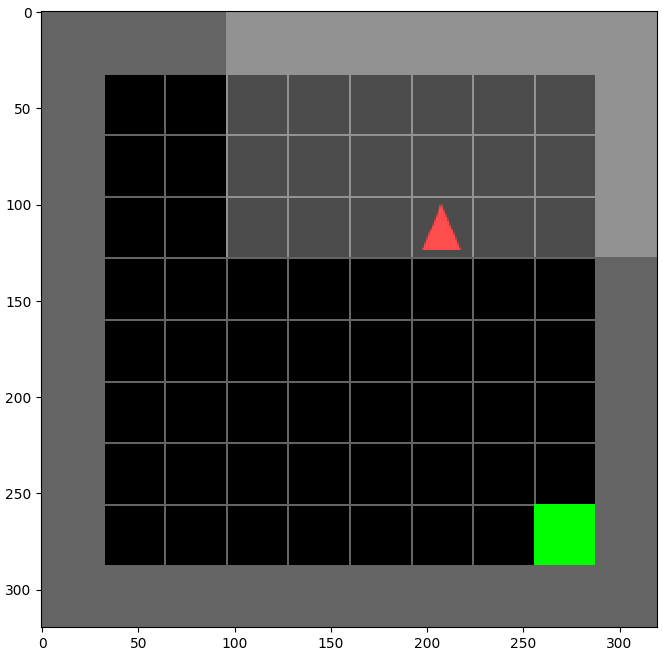

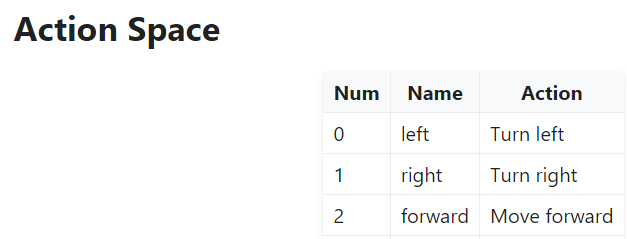

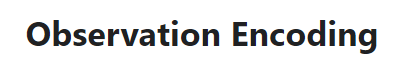

Agent Direction,
Agent Position,
Goal Position

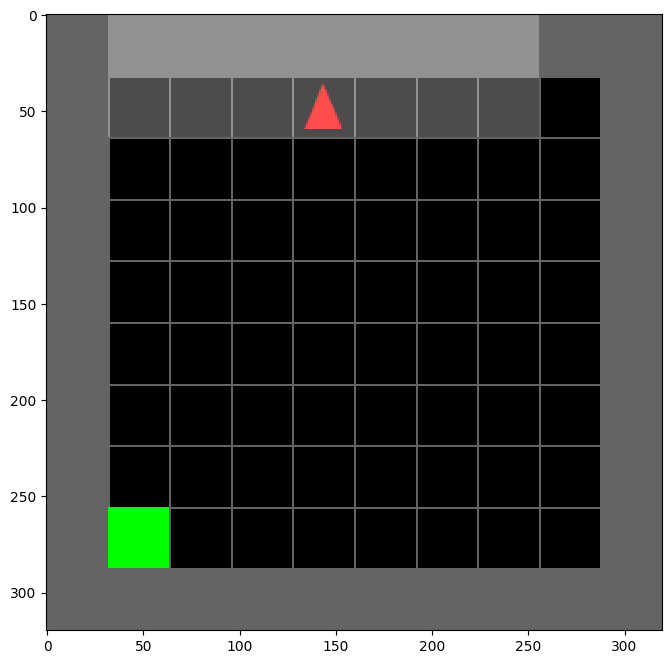

In [12]:
env = KeyFlatObsWrapper(RandomEmptyEnv_10 (render_mode='rgb_array', max_steps=100))
obs = env.reset()
screen = env.render()
plt.imshow(screen)

In [13]:
action_space = env.action_space
num_actions = action_space.n
print(f"Number of actions: {num_actions}")


Number of actions: 3


In [14]:
# obs = env.reset()
# # ============================================
# screen = env.render()
# plt.imshow(screen)
print('Map Height:', env.unwrapped.height-2)
print('Map Width:', env.unwrapped.width-2)
print('Agent Direction:', env.get_direction())
print('Agent Position:', env.get_position())
print('Goal position: ', env.get_goal_pos())
# print('Carrying Key:', env.is_carrying_key())
# print('Door Open:', env.is_door_open())

Map Height: 8
Map Width: 8
Agent Direction: 3
Agent Position: (4, 1)
Goal position:  (1, 8)


In [15]:
#Random action plus visualization
max_steps = 100
env = KeyFlatObsWrapper(RandomEmptyEnv_10 (render_mode='rgb_array', max_steps=max_steps))
obs = env.reset()
video_filename = 'fn.mp4'

with imageio.get_writer(video_filename, fps=10) as video:
  obs = env.reset()
  done = False
  total_reward = 0
  for step in range(max_steps):
      action = random.randint(0, num_actions - 1)
      obs, reward, terminated, truncated, _ = env.step(action)
      done = terminated or truncated #
      next_obs = obs  # Get agent's position directly from the environment
      video.append_data(env.render())
      if done:
        print("done","reward=", total_reward,"num_of_steps=",step)
        break
embed_mp4(video_filename)

done reward= 0 num_of_steps= 99


# RandomKeyMEnv_10

### Description

This environment has a key that the agent must pick up in order to unlock a goal and then get to the green goal square.

- Wall is always in the third column.

- Key is always in the left part (left to the door).

- Goal is randomly in the right upper or lower corner.

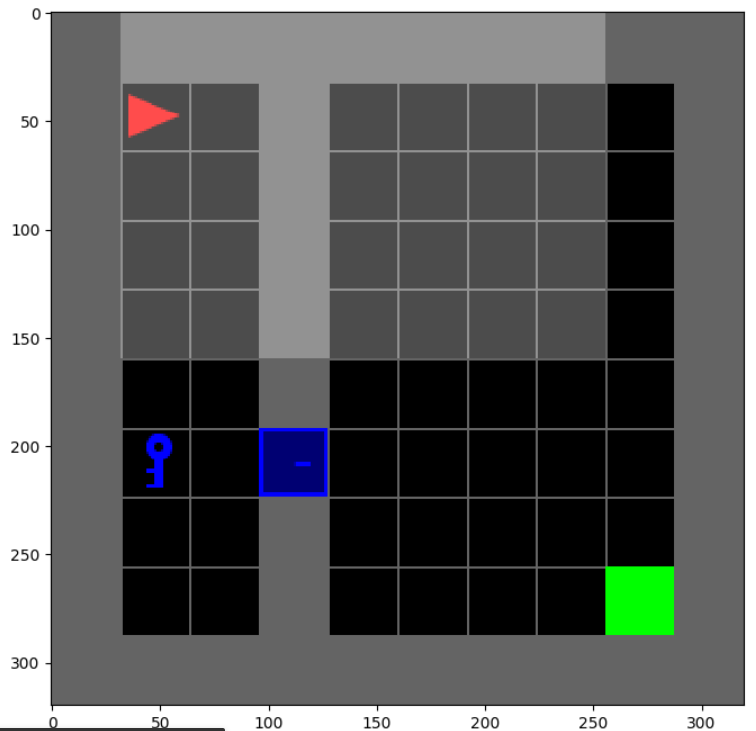

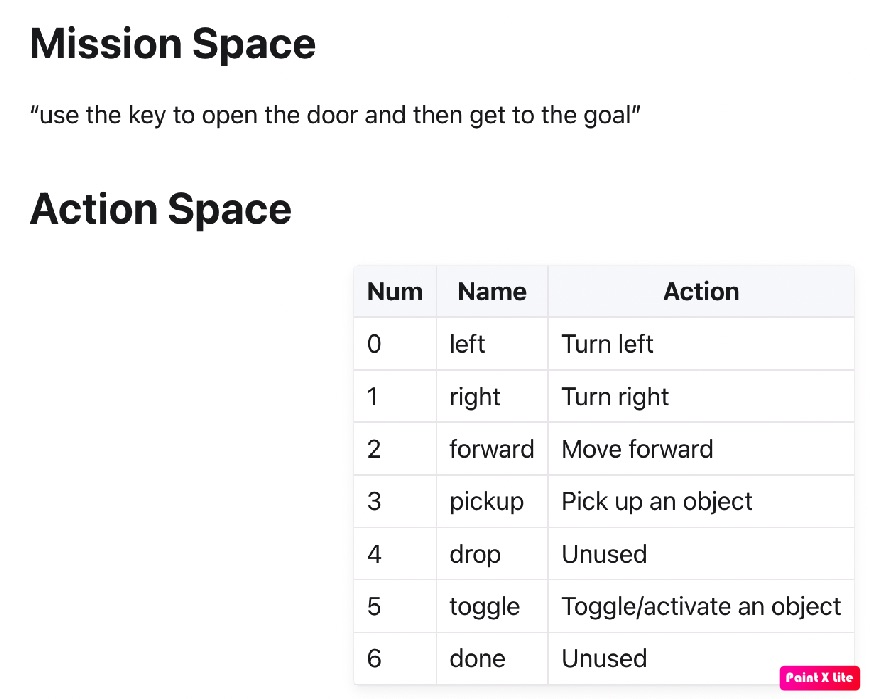

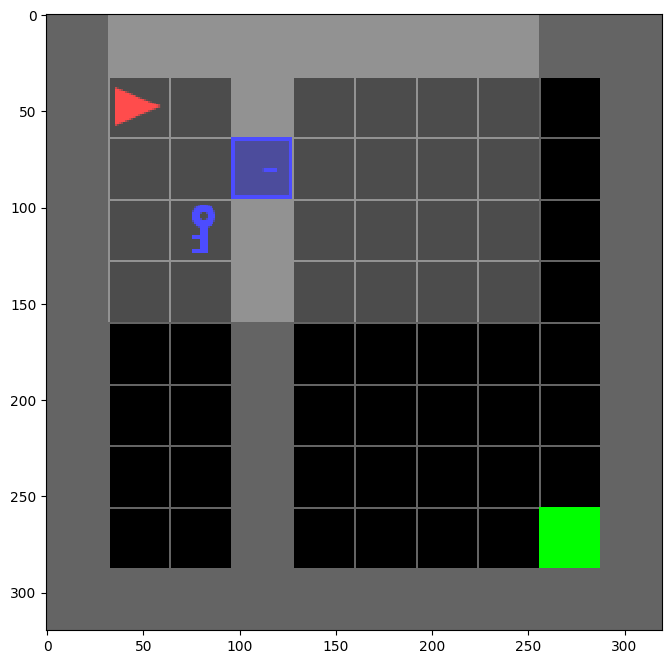

In [16]:
#=============== DO NOT DELETE ===============
# random.seed(42)
env = KeyFlatObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array', max_steps=100))

obs = env.reset()
# ============================================
screen = env.render()
plt.imshow(screen)

In [17]:
action_space = env.action_space
num_actions = action_space.n
print(f"Number of actions: {num_actions}")

Number of actions: 7


In [18]:
# env = KeyFlatObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array'))
# obs = env.reset()
# ============================================
# screen = env.render()
# plt.imshow(screen)
print('Map Height:', env.unwrapped.height-2)
print('Map Width:', env.unwrapped.width-2)
print('Agent Direction:', env.get_direction())
print('Agent Position:', env.get_position())
print('Goal position: ', env.get_goal_pos())
print('Carrying Key:', env.is_carrying_key())
print('Door Open:', env.is_door_open())

Map Height: 8
Map Width: 8
Agent Direction: 0
Agent Position: (1, 1)
Goal position:  (8, 8)
Carrying Key: False
Door Open: False


# Your Code Below

In [ ]:
### Montecarlo implemenation 

# Hyperparameters - Constants
NUM_EPISODES = 3000
EPSILON_START = 1.0
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.9
GAMMA = 0.99
ALPHA = 0.1  # Learning rate for Q-value updates

def select_action(state, Q, epsilon, env):
    """
    Select action using epsilon-greedy policy based on Q-values
    """
    # Convert state to tuple if it's a numpy array (for hashing)
    if isinstance(state, np.ndarray):
        state = tuple(state.flatten())
    
    # Epsilon-greedy policy
    if random.random() < epsilon:
        # Explore: choose random action
        return random.randint(0, env.action_space.n - 1)
    else:
        # Exploit: choose action with highest Q-value
        if state in Q:
            # Get action with maximum Q-value
            best_action = max(Q[state], key=Q[state].get)
            return best_action
        else:
            # If state not in Q, choose random action
            return random.randint(0, env.action_space.n - 1)
    
def generate_episode(env, Q, epsilon):
    """
    Generate a single episode using the current policy
    Returns: (episode, total_reward) where episode is a list of (state, action, reward) tuples
    """
    episode = []
    state, _ = env.reset()
    
    # Convert state to tuple if it's a numpy array (for hashing)
    if isinstance(state, np.ndarray):
        state = tuple(state.flatten())
    
    done = False
    total_reward = 0.0
    
    while not done:
        # Select action using epsilon-greedy policy
        action = select_action(state, Q, epsilon, env)
        
        # Take step in environment
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward
        
        # Convert next_state to tuple if it's a numpy array
        if isinstance(next_state, np.ndarray):
            next_state = tuple(next_state.flatten())
        
        # Store (state, action, reward) in episode
        episode.append((state, action, reward))
        
        # Update state for next iteration
        state = next_state
    
    return episode, total_reward

#Find best policy bt applyint monte carlo
# Copyrights: I used https://colab.research.google.com/drive/1sN9qAJ-TLoXKEtMbpz7qyUqx4IXPXHLJ?usp=sharing#scrollTo=tYGPv5to1sZ9
def monte_carlo_control(env, numEpisodes=NUM_EPISODES, epsilon_start=EPSILON_START,
                       epsilon_min=EPSILON_MIN, epsilon_decay=EPSILON_DECAY, gamma=GAMMA, alpha=ALPHA):

    Q = {}  # State-action value function
    state_values = {}  # For visualization

    # --- ADD THIS: List to track steps per episode ---
    training_steps = []
    # --- ADD THIS: List to track rewards per episode during training ---
    training_rewards = []
    # --- ADD THIS: List to track epsilon values per episode ---
    training_epsilons = []
    
    # Video filenames for recording
    mid_training_video = 'mid_training.mp4'
    final_video = 'final_trained.mp4'
    mid_training_recorded = False

    for episode_num in range(numEpisodes):
        
        # Decay epsilon
        epsilon = max(epsilon_min, epsilon_start * (epsilon_decay ** episode_num))

        if episode_num % 100000 == 0:
             print(f"Episode {episode_num}, epsilon: {epsilon:.3f}")
        
        # Record video at mid-training
        if not mid_training_recorded and episode_num >= numEpisodes // 2:
            print(f"\nRecording mid-training video at episode {episode_num}...")
            # Create temporary policy from current Q-values
            temp_policy = {state: max(actions.items(), key=lambda x: x[1])[0]
                          for state, actions in Q.items() if state in Q}
            record_episode_video(env, Q, temp_policy, mid_training_video, max_steps=200, epsilon=0.0)
            mid_training_recorded = True
            print(f"Mid-training video saved to {mid_training_video}\n")
        
        # Generate episode
        episode, episode_reward = generate_episode(env, Q, epsilon)
        
        training_steps.append(len(episode))
        training_rewards.append(episode_reward)
        training_epsilons.append(epsilon)
        # First-visit MC
        G = 0
        visited_state_actions = set()

        for t in range(len(episode)-1, -1, -1):
            state, action, reward = episode[t]
            G = gamma * G + reward

            if (state, action) not in visited_state_actions:
                visited_state_actions.add((state, action))

                # Initialize if needed
                if state not in Q:
                    Q[state] = {action: 0.0 for action in range(env.action_space.n)}

                # Update Q-value using constant learning rate alpha
                Q[state][action] += alpha * (G - Q[state][action])

                # Update state value for visualization
                state_values[state] = max(Q[state].values())
    

    # Create deterministic policy from Q-values
    policy = {state: max(actions.items(), key=lambda x: x[1])[0]
             for state, actions in Q.items()}
    
    # Record final video after training
    print(f"\nRecording final trained agent video...")
    record_episode_video(env, Q, policy, final_video, max_steps=200, epsilon=0.0)
    print(f"Final video saved to {final_video}\n")
    
    # --- ADD THIS: Plotting Logic ---
    plot_learning_curve(training_steps, training_epsilons, "Training: Average Steps to Finish")

    return policy, state_values, Q, mid_training_video, final_video, training_rewards

def plot_learning_curve(steps, epsilons, title):
    fig, ax1 = plt.subplots(figsize=(10, 5))
    
    # Calculate moving average (window of 100 episodes) to smooth the line
    window = 100
    if len(steps) > window:
        smooth_steps = np.convolve(steps, np.ones(window)/window, mode='valid')
        smooth_epsilons = np.convolve(epsilons, np.ones(window)/window, mode='valid')
        episodes = np.arange(window-1, len(steps))
    else:
        smooth_steps = steps
        smooth_epsilons = epsilons
        episodes = np.arange(len(steps))
    
    # Plot steps on primary y-axis
    color1 = 'tab:blue'
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Steps to Success", color=color1)
    ax1.plot(episodes, smooth_steps, color=color1, label='Steps to Success')
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True)
    
    # Plot epsilon on secondary y-axis
    ax2 = ax1.twinx()
    color2 = 'tab:red'
    ax2.set_ylabel("Epsilon", color=color2)
    ax2.plot(episodes, smooth_epsilons, color=color2, label='Epsilon', linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color2)
    
    plt.title(title)
    fig.tight_layout()
    plt.show()

def evaluate_policy(env, policy, Q, num_episodes=100, epsilon=0.0):
    """
    Evaluate the trained policy by running episodes and collecting rewards
    
    Args:
        env: The environment
        policy: Policy dictionary (state -> action)
        Q: Q-value dictionary (for fallback if policy doesn't have state)
        num_episodes: Number of episodes to run for evaluation
        epsilon: Epsilon for epsilon-greedy (0.0 means fully greedy/exploitative)
    
    Returns:
        List of rewards per episode
    """
    evaluation_rewards = []
    
    for episode_num in range(num_episodes):
        state, _ = env.reset()
        
        # Convert state to tuple if it's a numpy array
        if isinstance(state, np.ndarray):
            state = tuple(state.flatten())
        
        done = False
        episode_reward = 0.0
        
        while not done:
            # Select action using policy or Q-values
            if policy is not None and state in policy:
                action = policy[state]
            elif state in Q:
                # Use epsilon-greedy with Q-values
                if random.random() < epsilon:
                    action = random.randint(0, env.action_space.n - 1)
                else:
                    action = max(Q[state], key=Q[state].get)
            else:
                # Random action if state not seen
                action = random.randint(0, env.action_space.n - 1)
            
            # Take step
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
            
            # Convert next_state to tuple if it's a numpy array
            if isinstance(next_state, np.ndarray):
                next_state = tuple(next_state.flatten())
            
            state = next_state
        
        evaluation_rewards.append(episode_reward)
    
    return evaluation_rewards

def plot_average_rewards(rewards, title="Average Rewards per Episode", window=100):
    """
    Plot average rewards per episode with moving average smoothing
    
    Args:
        rewards: List of rewards per episode
        title: Title for the plot
        window: Window size for moving average
    """
    plt.figure(figsize=(10, 5))
    
    # Calculate moving average to smooth the line
    if len(rewards) > window:
        smooth_rewards = np.convolve(rewards, np.ones(window)/window, mode='valid')
        plt.plot(smooth_rewards, label=f'Moving Average (window={window})')
    else:
        plt.plot(rewards, label='Rewards')
    
    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print statistics
    print(f"\nReward Statistics:")
    print(f"  Mean reward: {np.mean(rewards):.4f}")
    print(f"  Std reward: {np.std(rewards):.4f}")
    print(f"  Min reward: {np.min(rewards):.4f}")
    print(f"  Max reward: {np.max(rewards):.4f}")
    print(f"  Success rate (reward > 0): {np.mean(np.array(rewards) > 0) * 100:.2f}%")

def record_episode_video(env, Q, policy, video_filename, max_steps=200, epsilon=0.0):
    """
    Record a video of an episode using the current Q-values/policy
    
    Args:
        env: The environment
        Q: Q-value dictionary (state -> action -> value)
        policy: Policy dictionary (state -> action), if None, will use Q-values
        video_filename: Output filename for the video
        max_steps: Maximum number of steps in the episode
        epsilon: Epsilon for epsilon-greedy (0.0 means fully greedy)
    """
    with imageio.get_writer(video_filename, fps=10) as video:
        state, _ = env.reset()
        
        # Convert state to tuple if it's a numpy array
        if isinstance(state, np.ndarray):
            state = tuple(state.flatten())
        
        done = False
        step = 0
        
        while not done and step < max_steps:
            # Record current frame
            frame = env.render()
            video.append_data(frame)
            
            # Select action using policy or Q-values
            if policy is not None and state in policy:
                action = policy[state]
            elif state in Q:
                # Use epsilon-greedy with Q-values
                if random.random() < epsilon:
                    action = random.randint(0, env.action_space.n - 1)
                else:
                    action = max(Q[state], key=Q[state].get)
            else:
                # Random action if state not seen
                action = random.randint(0, env.action_space.n - 1)
            
            # Take step
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Convert next_state to tuple if it's a numpy array
            if isinstance(next_state, np.ndarray):
                next_state = tuple(next_state.flatten())
            
            state = next_state
            step += 1
        
        # Record final frame
        frame = env.render()
        video.append_data(frame)

Episode 0, epsilon: 1.000

Recording mid-training video at episode 1500...
Mid-training video saved to mid_training.mp4


Recording final trained agent video...
Final video saved to final_trained.mp4



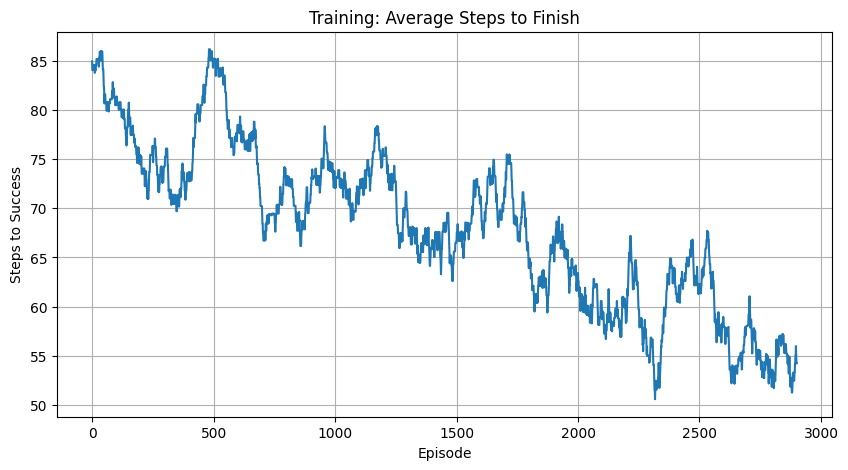


Training Rewards (during training phase)


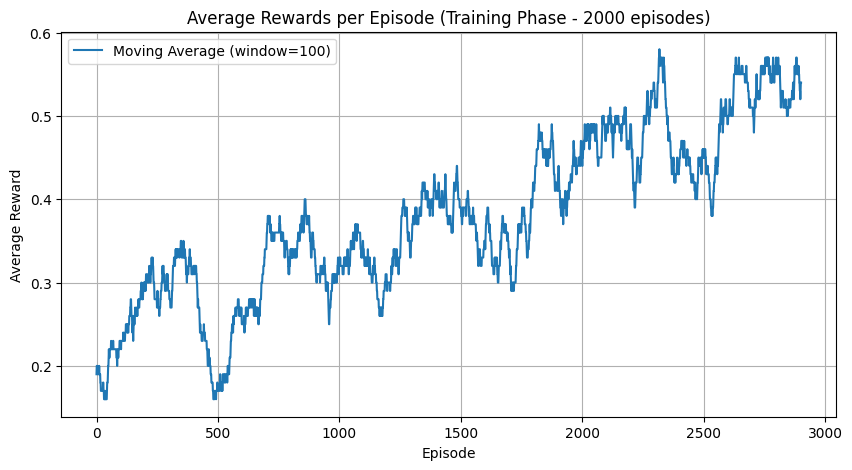


Reward Statistics:
  Mean reward: 0.3770
  Std reward: 0.4846
  Min reward: 0.0000
  Max reward: 1.0000
  Success rate (reward > 0): 37.70%

Evaluating trained policy (after training phase)...


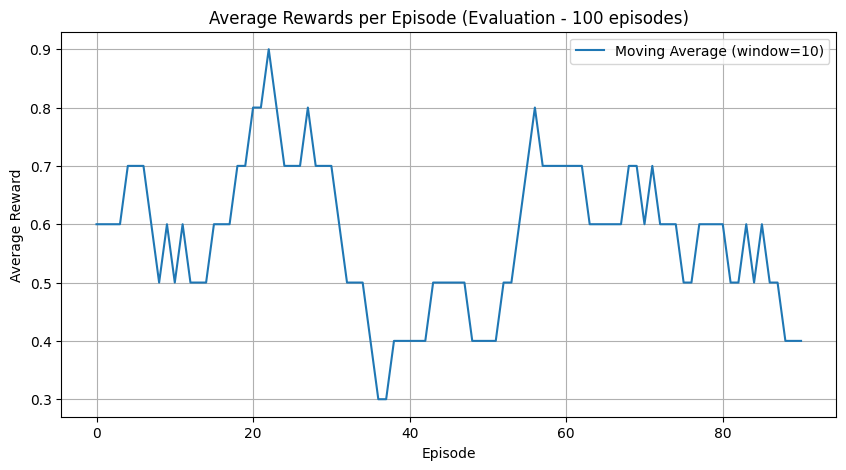


Reward Statistics:
  Mean reward: 0.5700
  Std reward: 0.4951
  Min reward: 0.0000
  Max reward: 1.0000
  Success rate (reward > 0): 57.00%


In [70]:
# Test the Monte Carlo implementation with a small number of episodes
# Create environment
from re import A


env = KeyFlatObsWrapper(RandomEmptyEnv_10(render_mode='rgb_array', max_steps=100))

policy, state_values, Q, mid_training_video, final_video, training_rewards = monte_carlo_control(
    env, 
    numEpisodes=NUM_EPISODES,  # Override for quick test
    epsilon_start=EPSILON_START,
    epsilon_min=EPSILON_MIN,
    epsilon_decay=EPSILON_DECAY,
    gamma=GAMMA,
    alpha=ALPHA
)

# Plot training rewards (optional - shows learning progress during training)
print("\n" + "="*50)
print("Training Rewards (during training phase)")
print("="*50)
plot_average_rewards(training_rewards, title=f"Average Rewards per Episode (Training Phase - {TEST_EPISODES} episodes)", window=100)

# Evaluate the trained policy after training
print("\n" + "="*50)
print("Evaluating trained policy (after training phase)...")
print("="*50)
EVALUATION_EPISODES = 100  # Number of episodes to evaluate
evaluation_rewards = evaluate_policy(env, policy, Q, num_episodes=EVALUATION_EPISODES, epsilon=0.0)

# Plot average rewards from evaluation (this is the main requirement)
plot_average_rewards(evaluation_rewards, title=f"Average Rewards per Episode (Evaluation - {EVALUATION_EPISODES} episodes)", window=10)



## Training Videos

The videos below show the agent's performance during and after training.


### Mid-Training Performance

This video shows the agent's performance in the middle of the training process:


In [71]:
# Display mid-training video
print("Mid-Training Video:")
embed_mp4(mid_training_video)


Mid-Training Video:


### Final Trained Agent Performance

This video shows the agent's performance after training is complete and the policy has converged:


In [72]:
# Display final trained agent video
print("Final Trained Agent Video:")
embed_mp4(final_video)


Final Trained Agent Video:
